# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psutil
from pathlib import Path
from tqdm import tqdm

from modules.preprocessing import AudioPreprocessor
from modules.feature_extraction import FeatureExtractor
from modules.pipelines import ModelPipeline
# from modules.evaluate import PerformanceAnalyzer

from models.lightgbm import LightGBMModel
from models.xgboost import XGBoostModel
from models.svm import SVMModel
# from models.catboost import CatBoostModel
# from models.gmboost import GradientBoostingModel

from concurrent.futures import ThreadPoolExecutor, as_completed

import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
from config import run_config, NUM_WORKERS, DATA_DIR, AUDIO_PATH

run_config()

# Helper Functions

In [3]:
def plot_feature_importances(model, feature_names):
    # Extract feature importances and feature names
    feature_importances = model.model.model.feature_importances_
    # Generate default feature names if not provided
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(feature_importances))]

    # Plot feature importances
    plt.figure(figsize=(10, len(feature_importances) * 0.2))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

# Load Dataset

In [4]:
df = pd.read_csv(DATA_DIR / "filtered_data_labeled.tsv", sep='\t')
df.head(1)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,label
0,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,fifties,female,us,3


In [5]:
df['path'] = df['path'].apply(lambda x: AUDIO_PATH / x)
df.head(1)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,label
0,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,data\audios\common_voice_en_19687170.mp3,He associated with the Formists.,2,1,fifties,female,us,3


# Features

In [6]:
from typing import Optional, Tuple, List

# === Parallel Processing ===
def process_sample(
    row: pd.Series, 
    idx: int, 
    mode: str, 
    preprocessor: AudioPreprocessor, 
    extractor: FeatureExtractor, 
    force_update: bool,
    ignore_not_cached: bool = False
) -> Optional[Tuple[int, np.ndarray, str]]:

    y_proc: Optional[np.ndarray] = preprocessor.load_cached_preprocessed(idx)

    if ignore_not_cached and y_proc is None:
        # print(f"Skipping index {idx} as it is not cached.")
        return None

    # Load and preprocess audio if not cached or force_update is True
    if force_update or y_proc is None:
        y_raw: Optional[np.ndarray] = preprocessor.load_audio(row['path'])
        if y_raw is None:
            # print(f"Failed to load audio for index {idx}.")
            return None
        y_proc = preprocessor.preprocess(y_raw, label=row['label'])
        preprocessor.cache_preprocessed(idx, y_proc, force_update)
    
    # Extract features
    feat = extractor.extract(y_proc, sr=16000, mode=mode, n_mfcc=20)
    return idx, feat, row['label']


def process_batch(
    batch_df: pd.DataFrame, 
    mode: str, 
    preprocessor: AudioPreprocessor, 
    extractor: FeatureExtractor, 
    force_update: bool, 
    offset: int = 0,
    ignore_not_cached: bool = False
) -> List[Tuple[int, np.ndarray, str]]:
    results: List[Tuple[int, np.ndarray, str]] = []
    
    # for i, row in batch_df.iterrows():
    for i, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {offset}", leave=False):
        result: Optional[Tuple[int, np.ndarray, str]] = process_sample(row, i, mode, preprocessor, extractor, force_update, ignore_not_cached)
        # print(f"Processed index {i} with label {row['label']}")
        # if result is None: print(f"Skipping index {i} due to processing error.")
        if result: results.append(result)
    
    return results

In [7]:
def prepare_features_parallel(df, mode="traditional", version: Optional[int] = None, force_update_preprocessing=False, force_update_features=False, batch_size=None, ignore_not_cached: bool = False
):
    print(f"🔄 Preparing features in {mode} mode...")
    extractor = FeatureExtractor()
    # Get current version of features
    latest_version = extractor.get_latest_version(mode)
    if version is None: version = latest_version
    X_cached, y_cached = extractor.load_cached_features(mode, version=version)
    if X_cached is not None and not force_update_features:
        return X_cached, y_cached
    
    print("🔄 Loading and preprocessing audio...")
    preprocessor = AudioPreprocessor()
    features_dict, labels_dict = {}, {}

    # Auto-select batch size based on available memor
    total_memory_gb = psutil.virtual_memory().total / (1024 ** 3)
    est_mem_per_sample = 0.01 if mode == "traditional" else 0.2
    est_batch_size = max(10, int((total_memory_gb * 0.4) / est_mem_per_sample))
    batch_size = batch_size or min(est_batch_size, len(df) // NUM_WORKERS)
    if total_memory_gb < 2:
        print("⚠️ Warning: Low memory detected. Reducing batch size to avoid OOM errors.")
        batch_size = min(batch_size, 10)
    print(f"🧠 Auto-selected batch size: {batch_size} (Estimated memory per sample: {est_mem_per_sample:.2f} GB, Total RAM: {total_memory_gb:.2f} GB)")

    batches = [df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size)]
    print(f"🔄 Total batches: {len(batches)}")

    print("📦 Processing batches:")
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(process_batch, batch, mode, preprocessor, extractor, force_update_preprocessing, i, ignore_not_cached=ignore_not_cached): i
            for i, batch in enumerate(batches)
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc="📊 Batches Done"):
            try:
                batch_results = future.result()
                if batch_results:
                    for idx, feat, label in batch_results:
                        features_dict[idx] = feat
                        labels_dict[idx] = label
            except Exception as e:
                print(f"⚠️ Error processing batch: {futures[future]} - {e}")

    print("🔄 Finished processing batches.")
    sorted_indices = sorted(features_dict.keys())
    X = np.array([features_dict[i] for i in sorted_indices])
    y = np.array([labels_dict[i] for i in sorted_indices])
    extractor.cache_features(X, y, version=latest_version + 1, mode=mode, force_update=force_update_features)
    return X, y

In [8]:
# X, y = prepare_features_parallel(df, mode="traditional", force_update_features=True, force_update_preprocessing=True, ignore_not_cached=False) # , batch_size=250
X, y = prepare_features_parallel(df, mode="traditional", version=3, force_update_features=False, force_update_preprocessing=False, ignore_not_cached=False) # , batch_size=250

🔄 Preparing features in traditional mode...


In [9]:
X.shape, y.shape

((172158, 54), (172158,))

# Split Dataset

In [10]:
train_size = 0.9
val_size = 0.07
apply_smote = False

In [11]:
preprocessor = AudioPreprocessor()
X_train, y_train, X_val, y_val, X_test, y_test = preprocessor.split_data(
    X, y, train_size=train_size, val_size=val_size, random_state=42, stratify=True, apply_smote=apply_smote
)

In [12]:
# # Remove features from 40 to 119 inclusive
# X_train = np.delete(X_train, np.s_[40:120], axis=1)
# X_val = np.delete(X_val, np.s_[40:120], axis=1)
# X_test = np.delete(X_test, np.s_[40:120], axis=1)
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

# Models

In [ ]:
# LightGBM
lightgbm_model = ModelPipeline(model=LightGBMModel)
metrics = lightgbm_model.train(
    X_train, y_train, X_val, y_val, X_test, y_test, use_optuna=True, n_trials=15, class_weight_type="balanced",
)
metrics

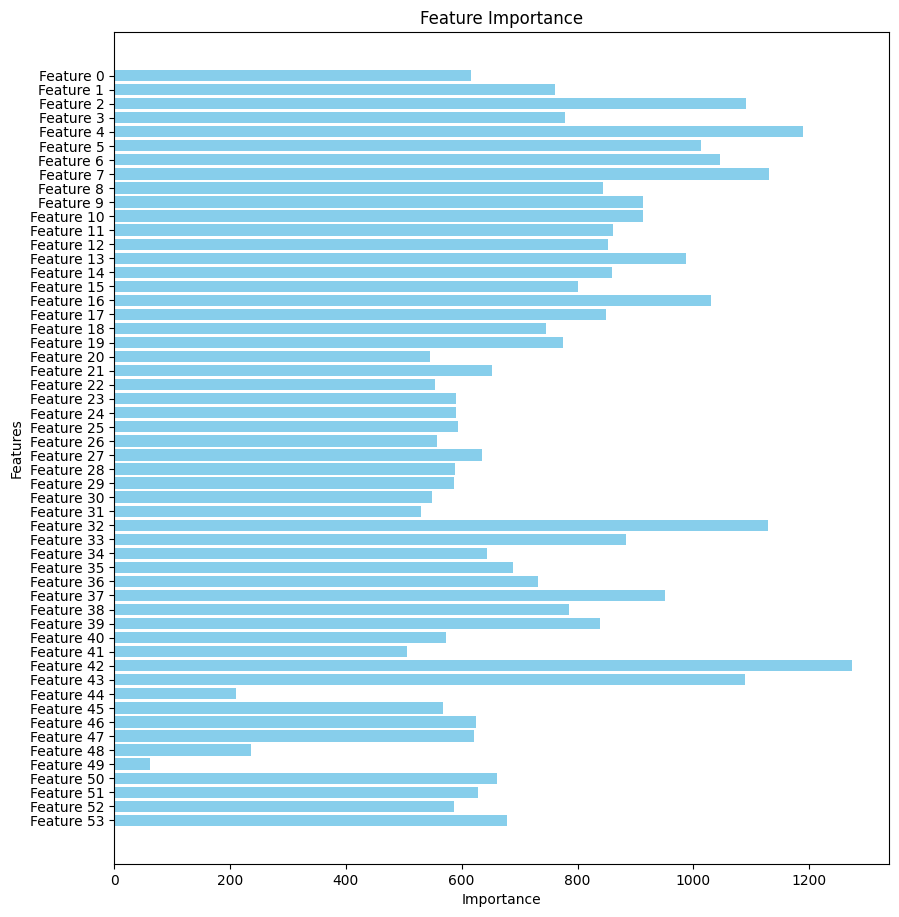

In [14]:
plot_feature_importances(lightgbm_model, feature_names=None)

In [15]:
# XGBoost
xgboost_model = ModelPipeline(model=XGBoostModel)
# xgboost_model.best_params = {'learning_rate': 0.09674256765262308, 'max_depth': 20, 'n_estimators': 700, 'subsample': 0.5613047304929308, 'colsample_bytree': 0.7956368393113393}
metrics = xgboost_model.train(
    X_train, y_train, X_val, y_val, X_test, y_test, use_optuna=True, n_trials=10, class_weight_type="balanced",
) # , experiment_name="XGBoost_Experiment"
metrics

[I 2025-05-08 00:00:58,582] A new study created in memory with name: no-name-05cd1a2d-1fbd-4dc5-bb0e-acf4d63a2223


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-08 00:03:01,813] Trial 0 finished with value: 0.916604431167538 and parameters: {'learning_rate': 0.016003518304457856, 'max_depth': 18, 'n_estimators': 749, 'subsample': 0.9967780148968702, 'colsample_bytree': 0.7309891555219121, 'gamma': 3.7480955894653123, 'min_child_weight': 7, 'scale_pos_weight': 2.7943334352901337}. Best is trial 0 with value: 0.916604431167538.
[I 2025-05-08 00:03:53,555] Trial 2 finished with value: 0.9196747157912206 and parameters: {'learning_rate': 0.06965046825646097, 'max_depth': 20, 'n_estimators': 424, 'subsample': 0.6792632413542896, 'colsample_bytree': 0.9930481843526001, 'gamma': 2.0025706931421947, 'min_child_weight': 9, 'scale_pos_weight': 1.064274380022721}. Best is trial 2 with value: 0.9196747157912206.
[I 2025-05-08 00:03:56,046] Trial 1 finished with value: 0.9184300058086465 and parameters: {'learning_rate': 0.015869928722993837, 'max_depth': 20, 'n_estimators': 973, 'subsample': 0.8854980741923413, 'colsample_bytree': 0.71649091758

2025/05/08 00:10:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      3591\n           1       0.75      0.82      0.78       580\n           2       0.88      0.87      0.87       519\n           3       0.79      0.71      0.75       475\n\n    accuracy                           0.93      5165\n   macro avg       0.85      0.84      0.85      5165\nweighted avg       0.93      0.93      0.93      5165\n'

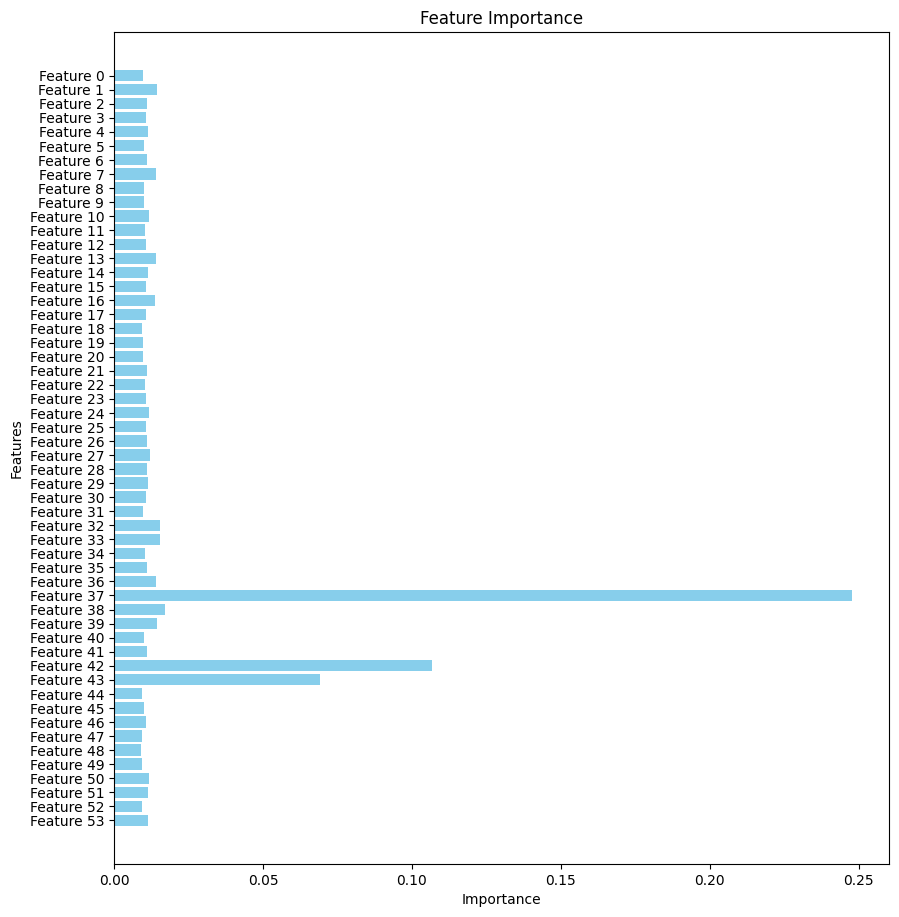

In [16]:
plot_feature_importances(xgboost_model, feature_names=None)

In [ ]:
# # SVM
# svm_model = ModelPipeline(model=SVMModel)
# metrics = svm_model.train(
#     X_train, y_train, X_val, y_val, X_test, y_test, use_optuna=True, n_trials=5, class_weight_type="balanced",
# ) # , experiment_name="SVM_Experiment"
# metrics

[I 2025-05-08 00:10:14,364] A new study created in memory with name: no-name-1e1dae50-7ce7-4fd8-adba-c016c2812cfe


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-05-08 00:30:49,520] Trial 0 finished with value: 0.6488258235831051 and parameters: {'C': 34.38582327326045, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.6488258235831051.
[I 2025-05-08 00:57:50,267] Trial 1 finished with value: 0.866152186540536 and parameters: {'C': 1.898666521849391, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.866152186540536.


In [ ]:
# plot_feature_importances(svm_model, feature_names=None)

LightGBM
precision    recall  f1-score   support

           0       0.96      1.00      0.97     11917
           1       0.98      0.98      0.98      1920
           2       0.99      0.71      0.83      1744
           3       0.98      0.96      0.97      1635

    accuracy                           0.96     17216
   macro avg       0.97      0.91      0.94     17216
weighted avg       0.96      0.96      0.96     17216

precision    recall  f1-score   support

           0       0.91      0.98      0.94     18009
           1       0.85      0.85      0.85      2915
           2       0.91      0.47      0.62      2579
           3       0.87      0.77      0.82      2321

    accuracy                           0.90     25824
   macro avg       0.88      0.77      0.81     25824
weighted avg       0.90      0.90      0.89     25824

precision    recall  f1-score   support

           0       0.94      0.90      0.92      5975
           1       0.81      0.89      0.85       989
           2       0.61      0.71      0.66       874
           3       0.78      0.82      0.80       770

    accuracy                           0.87      8608
   macro avg       0.79      0.83      0.81      8608
weighted avg       0.88      0.87      0.88      8608

precision    recall  f1-score   support

           0       0.93      0.87      0.90      5985
           1       0.80      0.86      0.83       967
           2       0.51      0.66      0.57       865
           3       0.78      0.81      0.80       791

    accuracy                           0.85      8608
   macro avg       0.75      0.80      0.77      8608
weighted avg       0.86      0.85      0.85      8608

precision    recall  f1-score   support

           0       0.93      0.89      0.91      5985
           1       0.81      0.86      0.84       967
           2       0.54      0.68      0.60       865
           3       0.80      0.81      0.80       791

    accuracy                           0.86      8608
   macro avg       0.77      0.81      0.79      8608
weighted avg       0.87      0.86      0.86      8608

precision    recall  f1-score   support

           0       0.98      0.98      0.98      3591
           1       0.73      0.77      0.75       580
           2       0.88      0.86      0.87       519
           3       0.74      0.67      0.70       475

    accuracy                           0.92      5165
   macro avg       0.83      0.82      0.83      5165
weighted avg       0.92      0.92      0.92      5165



XGBoost
precision    recall  f1-score   support

           0       0.91      0.99      0.95     18009
           1       0.86      0.87      0.86      2915
           2       0.97      0.48      0.64      2579
           3       0.89      0.79      0.84      2321

    accuracy                           0.91     25824
   macro avg       0.91      0.78      0.82     25824
weighted avg       0.91      0.91      0.90     25824

precision    recall  f1-score   support

           0       1.00      1.00      1.00     11917
           1       1.00      1.00      1.00      1920
           2       1.00      1.00      1.00      1744
           3       1.00      1.00      1.00      1635

    accuracy                           1.00     17216
   macro avg       1.00      1.00      1.00     17216
weighted avg       1.00      1.00      1.00     17216

precision    recall  f1-score   support

           0       0.90      0.99      0.94     18009
           1       0.84      0.86      0.85      2915
           2       0.97      0.43      0.60      2579
           3       0.88      0.76      0.82      2321

    accuracy                           0.90     25824
   macro avg       0.90      0.76      0.80     25824
weighted avg       0.90      0.90      0.89     25824

precision    recall  f1-score   support

           0       0.93      0.95      0.94      5975
           1       0.82      0.90      0.85       989
           2       0.77      0.60      0.68       874
           3       0.84      0.78      0.81       770

    accuracy                           0.89      8608
   macro avg       0.84      0.81      0.82      8608
weighted avg       0.89      0.89      0.89      8608

precision    recall  f1-score   support

           0       0.98      0.98      0.98      3591
           1       0.75      0.80      0.78       580
           2       0.88      0.87      0.88       519
           3       0.78      0.69      0.73       475

    accuracy                           0.93      5165
   macro avg       0.85      0.84      0.84      5165
weighted avg       0.93      0.93      0.93      5165


# Save Model to Registry

In [13]:
model = ModelPipeline(model=XGBoostModel)
# model.load_model(run_id="a1d199698bf54bed8a9d19f48d578011")
# model.register_model(run_id="a1d199698bf54bed8a9d19f48d578011", model_name="XGBoost")

In [15]:
model.load_model_from_registry(model_name="XGBoost")

In [16]:
model.classification_report(X_test, y_test)

'              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      3591\n           1       0.75      0.82      0.78       580\n           2       0.88      0.87      0.87       519\n           3       0.79      0.71      0.75       475\n\n    accuracy                           0.93      5165\n   macro avg       0.85      0.84      0.85      5165\nweighted avg       0.93      0.93      0.93      5165\n'

## Load Models

In [ ]:
lightgbm_model = ModelPipeline(model=LightGBMModel)
lightgbm_model.load_model(best_metric="weighted avg_f1-score")
lightgbm_model.classification_report(X, y)

# Test Inference

In [ ]:
# === Batch Inference Utility ===
def run_batch_inference(model, input_folder, output_path, sr=16000, feature_mode="traditional"):
    extractor = FeatureExtractor()
    preprocessor = AudioPreprocessor()
    results = []

    for file in Path(input_folder).rglob("*.wav"):
        y = preprocessor.preprocess(preprocessor.load_audio(str(file), sr=sr))
        if y is not None:
            x = extractor.extract(y, sr=sr, mode=feature_mode).reshape(1, -1)
            pred = model.predict(x)[0]
            results.append({"file": file.name, "prediction": pred})

    df = pd.DataFrame(results)
    df.to_csv(output_path, index=False)
    print(f"✅ Batch inference saved to {output_path}")
